# Imports

Llevamos a cabo los imports necesarios para realizar los ejercicios de esta sección

In [1]:
!pip install h2o

     |████████████████████████████████| 164.6MB 61kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.4-py2.py3-none-any.whl size=164670979 sha256=746aa8ddf289b58e1ff48e50653c65f3fd69df6d2fd3d819b90fe9d1c704cb88
  Stored in directory: /root/.cache/pip/wheels/65/f4/0d/c9bb958d70c2e015c968cb91cbd7f1b486933056d422337d75
Successfully built h2o


In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Configuraciones

Definimos una serie de configuraciones que nos sirvan para todo el notebook

In [3]:
np.random.seed(1993)
%matplotlib inline

# Métodos paramétricos

Para el estudio de estas técnicas de detección de outliers, vamos a emplear un conjunto de datos generados aleatoriamente, que cumplen con la premisa que marcan los métodos parametricos dee que los datos siguen una distribución normal

In [4]:
numero_variables=4
df_normal = pd.DataFrame(np.random.normal(scale=10.0, 
                                        size=(1000, numero_variables)),
                           columns=['variable_{}'.format(i) for i in range(numero_variables)])
df_normal.head()

,variable_0,variable_1,variable_2,variable_3
0,-1.772075,-2.523558,-2.023786,5.173049
1,-5.139887,-4.579376,17.820728,0.564511
2,-12.888997,2.895660,0.710280,5.509234
3,2.628307,11.795127,-9.574134,1.311040
4,-9.469025,-14.903507,5.175685,2.776887


Ahora vamos a mirar a sus histoigramas, podemos observar como efectivamente, siguen una distribución normal

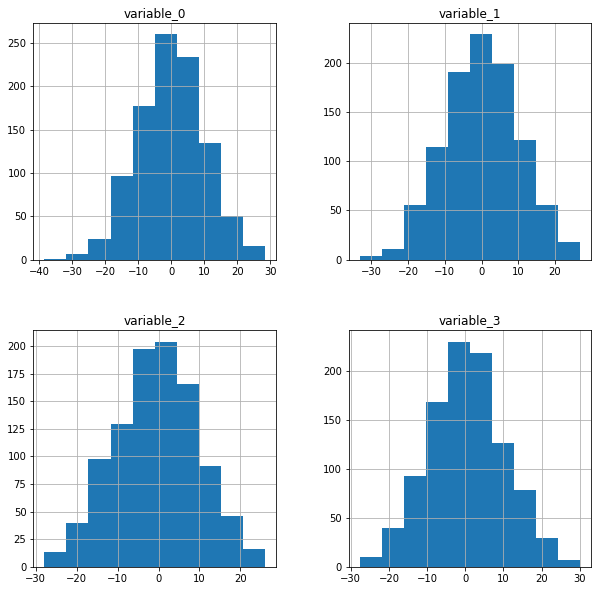

In [5]:
df_normal.hist(figsize=(10,10));

## Identificación de outliers en nuestros datos

Los metodos de detección de outliers parametricas más extendidos son:

    - Detección empleando la desviación estandar.
    - Detección empleando el rango interquantil.
    
Vamos a generar dos funciones que nos permitan calcular estos valores y aplicarlos sobre nuestras variables

### Metodo de la desviacion estandar

In [6]:
def fuera_std(s, nstd=3.0, return_thresholds=False):
    """
    Definir una funcion que devuelva si el punto de la variable se 
    encuentra dentro o fuera de la franja de desviaci'on estandar 
    de la distribuci'on de la variables.
    Si return_thresholds es True se le pedirá que nos mande los 
    umbrales en los que está haciendo el corte
    """
    data_media, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    limite_inferior, limite_superior = data_media - cut_off, data_media + cut_off
    if return_thresholds:
        return limite_inferior, limite_superior
    else:
        return [True if x < limite_inferior or x > limite_superior else False for x in s]

In [7]:
outliers_std = fuera_std(df_normal.variable_0,3,False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


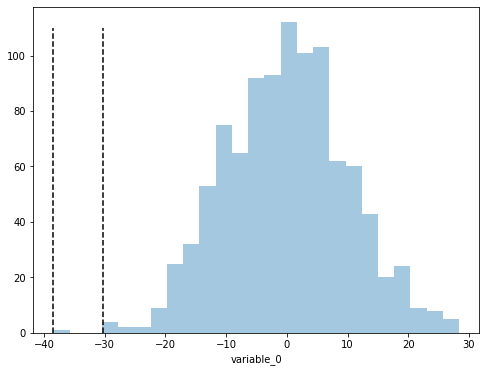

In [8]:
plt.figure(figsize=(8,6))
sns.distplot(df_normal['variable_0'], kde=False);
plt.vlines(df_normal['variable_0'][outliers_std], 
           ymin=0, ymax=110, 
           linestyles='dashed');

### Metodo del rango interquartil

In [9]:
def fuera_iqr(s, 
              k=1.5, 
              return_thresholds=False):
    """Calcula el IQR y lo multiplica por un k que define el 
   limite final para detectar outliers.
    Si return_thresholds es True se le pedirá que nos mande los 
    umbrales en los que está haciendo el corte.
   
    """
    # calcular IQR
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calcular el corte de los outliers
    cut_off = iqr * k
    limite_inferior, limite_superior = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return limite_inferior, limite_superior
    else: 
        return [True if x < limite_inferior or x > limite_superior else False for x in s]

In [10]:
outliers_iqr = fuera_iqr(df_normal.variable_0,1.5,False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


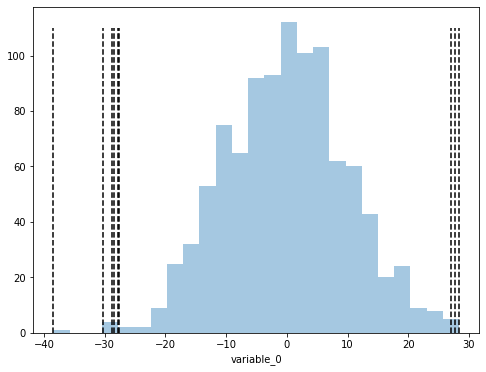

In [11]:
plt.figure(figsize=(8,6))
sns.distplot(df_normal['variable_0'], kde=False);
plt.vlines(df_normal['variable_0'][outliers_iqr], 
           ymin=0, ymax=110, 
           linestyles='dashed');

### Evolución del umbral en función de los multiplicadores que se atribuyan

Vamos a comprobar como varia el umbral con el que se corta a la distribución normal en función del multiplicador que se asocie a la desviación estandar o al rango interquantil

In [12]:
def plot_umbrales_std(dataframe, col, nstd=2.0, color='red'):
    """
    Plot de los limites de umbrales
    """
    inferior, superior = fuera_std(dataframe[col], nstd=nstd, return_thresholds=True)
    plt.axvspan(min(dataframe[col][dataframe[col] < inferior], 
                    default=dataframe[col].min()), 
                inferior, 
                alpha=0.2, 
                color=color);
    
    plt.axvspan(superior, max(dataframe[col][dataframe[col] > superior],
                           default=dataframe[col].max()), 
                alpha=0.2, 
                color=color);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


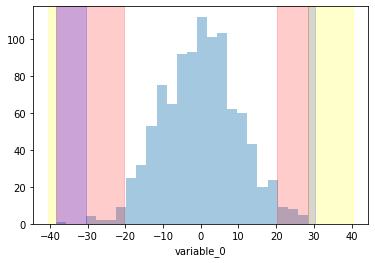

In [13]:
column = 'variable_0'
sns.distplot(df_normal[column], kde=False)
plot_umbrales_std(df_normal, column, nstd=2.0, color='red');
plot_umbrales_std(df_normal, column, nstd=3.0, color='blue');
plot_umbrales_std(df_normal, column, nstd=4.0, color='yellow');

In [ ]:
def plot_umbrales_iqr(dataframe, col, k=1.5, color='red'):
    """
    Plot de los limites de umbrales
    """
    inferior, superior = fuera_iqr(dataframe[col], k=k, return_thresholds=True)
    plt.axvspan(min(dataframe[col][dataframe[col] < inferior], 
                    default=dataframe[col].min()), 
                inferior, 
                alpha=0.2, 
                color=color);
    
    plt.axvspan(superior, max(dataframe[col][dataframe[col] > superior],
                           default=dataframe[col].max()), 
                alpha=0.2, 
                color=color);

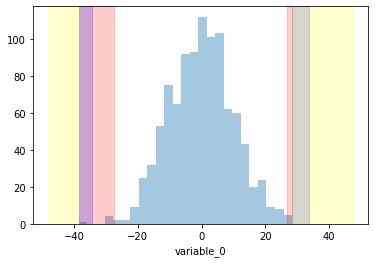

In [ ]:
column = 'variable_0'
sns.distplot(df_normal[column], kde=False)
plot_umbrales_iqr(df_normal, column, k=1.5, color='red');
plot_umbrales_iqr(df_normal, column, k=2.0, color='blue');
plot_umbrales_iqr(df_normal, column, k=3.0, color='yellow');

Podemos observar ocmo el IQR es mucho mas restrictivo que el metodo de la desviación

# Elaboración de gráficos Boxplot

## Lectura de los datos

Para el ejercicio de dibujar y trabajar ocn boxplot, emplearemos los datos de un dataset real que recoge cierta información sobre los coches que se están vendiendo en un portal web. este dataset recoge la sigueinte información:

**- car:** marca del coche

**- price:** precio de venta del anunciante (en dolares

**- body:** tipo de coche

**- mileage:** km que tiene el coche

**- engV:** rounded engine volume (‘000 cubic cm)

**- engType:** tipo de motor

**- registration:** si el coche esta registrado a nivel nacional.

**- year:** año de fabricación

**- model:** modelo especifico de coche

**- drive:** tipo de traccion


In [15]:
df_coches = pd.read_csv("https://raw.githubusercontent.com/jguijarh/The_Valley_outliers_and_residuals/main/anuncios-coche/car_ad.csv", sep=',', encoding='latin-1')
df_coches.head()

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91,NaN,Other,yes,2013,E-Class,NaN


A simple vista podemos ver como hay valores nulos y otros problemas que deberían solucionarse en una fase precia de EDA. Para no alargar el ejercicio ignoraremos estos pasos dado que no impactan directamente en lo que queremos realizar.

### Calcular la antiguedad y los kilometros anuales 

Lo primero que vamos a realizar en este ejercicio es calcular dos variables que pueden ser interesantes:

    - La antiguedad de los coches 
    - Las millas por año que han recorrido.
    
Eliminamos los coches nuevos para no meter ruido en los analisis futuros.

In [16]:
df_coches['antiguedad'] = 2016 - df_coches.year
df_coches['mileage_anio'] = (df_coches['mileage']/df_coches['antiguedad']).round(2)
df_coches = df_coches[df_coches['antiguedad']!=0]

## Dibujar boxplot

con los datos ya dispuestos, vamos a representar ciertas variables categoricas en función de otras numericas.

#### Boxplot de tipo de motor vs antiguedad del vehiculo
Llevar a cabo la representacion de boxplot teniendo en cuenta la variable tipo de motor y observar la antiguedad 

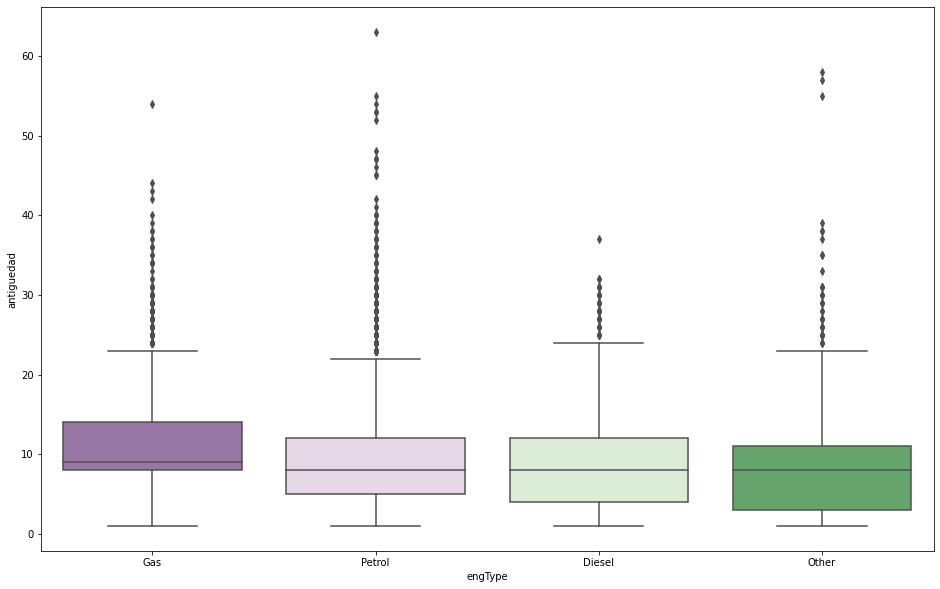

In [17]:
plt.figure(figsize=(16, 10))
sns.boxplot(x="engType", y="antiguedad",  data=df_coches, palette="PRGn");

Analicemos los resultados.

### Millas anuales vs antiguedad del vehículo
Llevar a cabo la representacion de boxplot teniendo en cuenta la agrupacion por la antiguedad de los coches

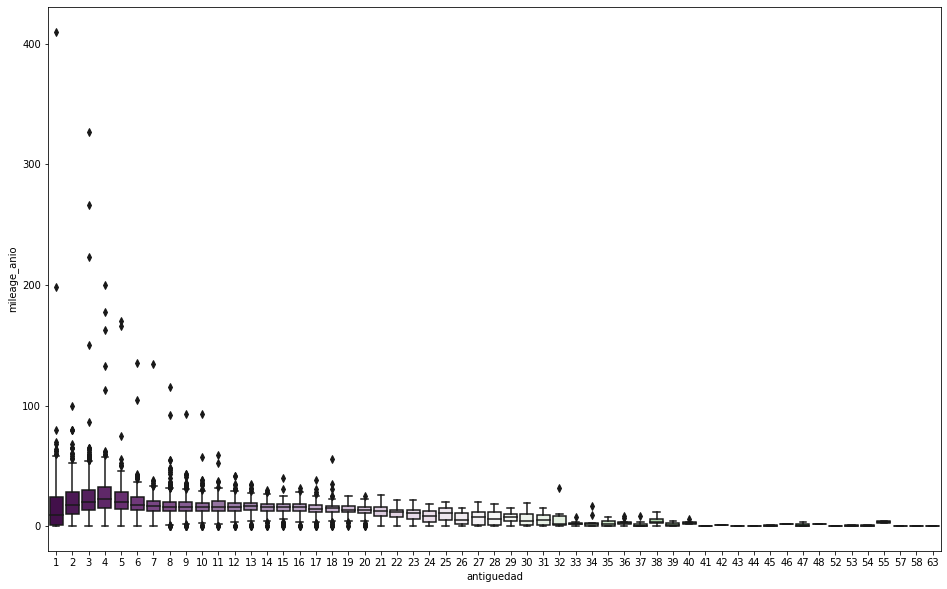

In [18]:
plt.figure(figsize=(16, 10))
sns.boxplot(x="antiguedad", 
            y="mileage_anio",
            data=df_coches, 
            palette="PRGn");

Analizamos los resultados

#### Obtengamos la evolución de las millas recorridas en un año (mediana)

In [19]:
df_anio_mileage = df_coches.groupby('antiguedad')['mileage_anio'].median().reset_index()
df_anio_mileage.head()

,antiguedad,mileage_anio
0,1,9.00
1,2,17.50
2,3,20.00
3,4,22.25
4,5,19.60


Lo dibujamos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


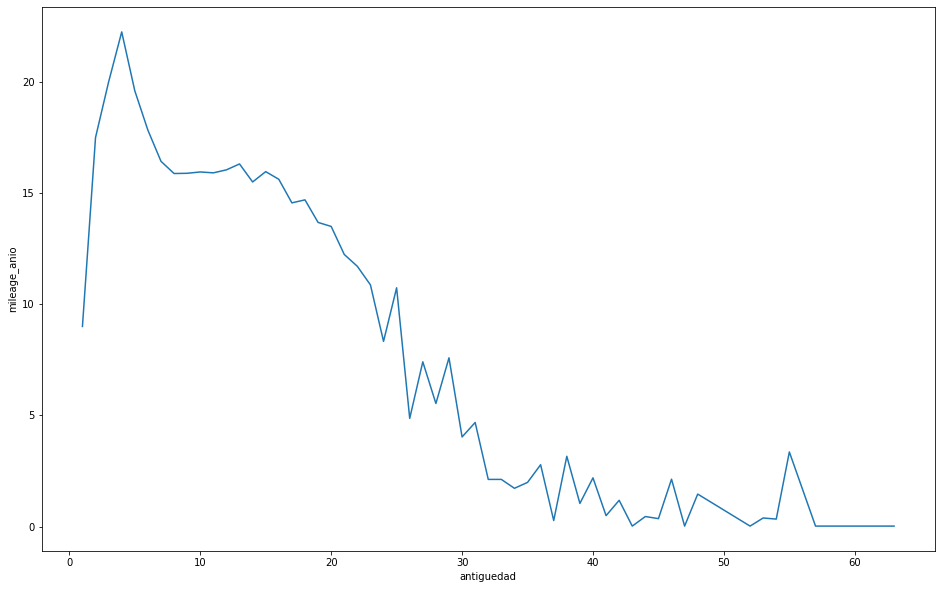

In [20]:
plt.figure(figsize=(16, 10))
sns.lineplot(df_anio_mileage.antiguedad,df_anio_mileage.mileage_anio)

Podemos observar ocmo hay ciertos tramos que tienen un comportamiento similar, que nos pueden permitir transformar nuestra variable continua antiguedad, en una varable por tramos que nos facilite el estudio del boxplot.

In [21]:
condiciones = [df_coches.antiguedad<=3, 
              (df_coches.antiguedad>3) & (df_coches.antiguedad<=6), 
              (df_coches.antiguedad>6) & (df_coches.antiguedad<=10),
             (df_coches.antiguedad>10) & (df_coches.antiguedad<=15),
             (df_coches.antiguedad>15) & (df_coches.antiguedad<=20),
              (df_coches.antiguedad>20) & (df_coches.antiguedad<=30),
             df_coches.antiguedad > 30]

intervalo = ['menos_de_3', 'entre_3_y_6','entre_6_y_10',
            'entre_10_y_15','entre_15_y_20','entre_20_y_30',
            'mas_de_30']
df_coches['antiguedad_group'] = np.select(condiciones, intervalo)

Volvemos a realizar el boxplot pero esta vez contra la nueva variable agrupada

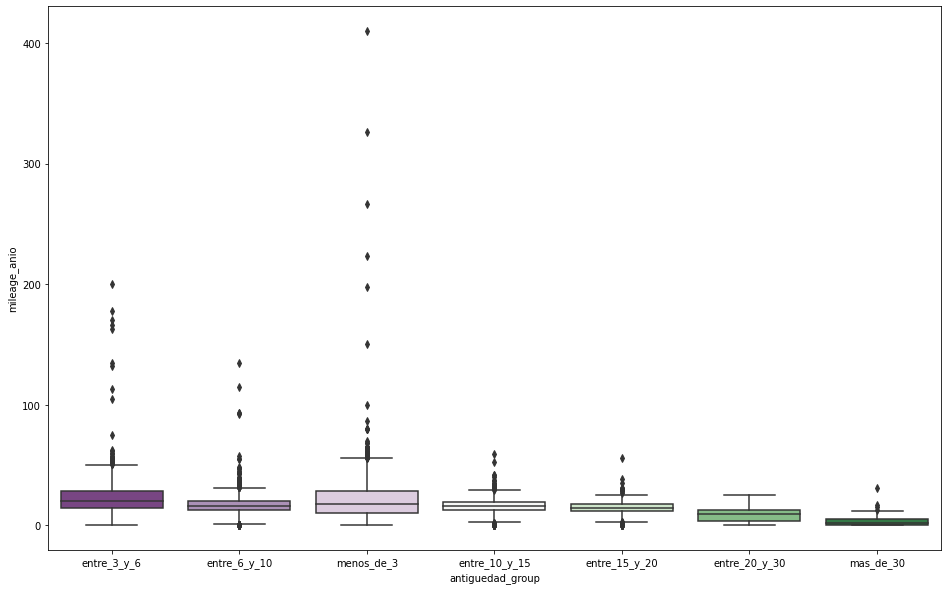

In [22]:
plt.figure(figsize=(16, 10))
sns.boxplot(x="antiguedad_group", 
            y="mileage_anio",
            data=df_coches, 
            palette="PRGn");

Analicemos el gráfico

# DBScan

Vamos a ver el funcionamiento de DBScan con dos tipos de datasets:

    - Un dataset de "juguete" para observar como se comporta el algoritmo.
    - Sobre un dataset y variable de un problema real, que es el de los precios de las casas de una ciudad, comparando sus metros cuadrados contra su precio

Generamos datos aleatorios con make_moons.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


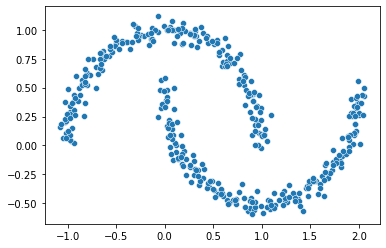

In [23]:
X, y = make_moons(n_samples=400, noise=0.05, random_state=0)
x = X[:, 0]
y = X[:, 1]
sns.scatterplot(x, y, legend = False);

Definimos un DBSCan con sklearn y predecimos los clusters

In [24]:
model = DBSCAN(eps = 0.2,
               min_samples=3)
clusters = model.fit_predict(X)

Nuestro modelo a identificado lo siguiente:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


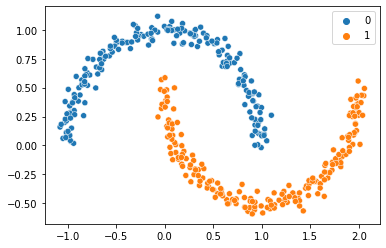

In [25]:
sns.scatterplot(x, y, hue = clusters);

Podemos jugar con el ruido que le metemos al modelo y con la parametrización del modelo DBSCAN para forzar situaciones con este ejemplo sencillo

### DBScan sobre los datos de pisos de Melbourne

Empleamos un dataset de casas de melbourne para examinar como identifica DBScan anomalias dentro de la relación entre dos de sus variables.

Este es un problema tipico de kaggle y estamos analizando la variable target del problema 'SalePrice' respecto a 'GrLivArea', que es una de las variables más importantes cuando se modeliza este problema, pues es el area del inmueble.

#### Leemos los datos

In [26]:
df_houses = pd.read_csv("https://raw.githubusercontent.com/jguijarh/The_Valley_outliers_and_residuals/main/precio-casas/train.csv")
df_houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Elaboramos una función que nos permite evaluar el rendimiento de DBScan en estos datos

In [27]:
def dbscan_outliers(df, 
                    var1,var2,
                    dbscan_eps,
                    dbscan_minsample,
                    get_cluster_num):
    '''Funcion que define los datos escalados que se le pasan y busca outliers mediante DBScan en ellos'''
    plt.figure(figsize=(8,8))
    
    scaler = RobustScaler()
    scale_var1 = scaler.fit_transform(pd.DataFrame((df[var1]))).reshape(1,-1)[0]
    scale_var2 = scaler.fit_transform(pd.DataFrame((df[var2]))).reshape(1,-1)[0]
    
    df_temp = pd.DataFrame({"var1":scale_var1 ,
                            "var2":scale_var2})
    
    clustering = DBSCAN(eps=dbscan_eps, 
                        min_samples=dbscan_minsample).fit(df_temp.values)
    
    df_temp["c"] = clustering.labels_
    df_temp.index = df.index
    sns.scatterplot(scale_var1,scale_var2, 
                    hue=clustering.labels_)
    return df_temp[df_temp["c"]==get_cluster_num].index

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Outliers identificados: 77


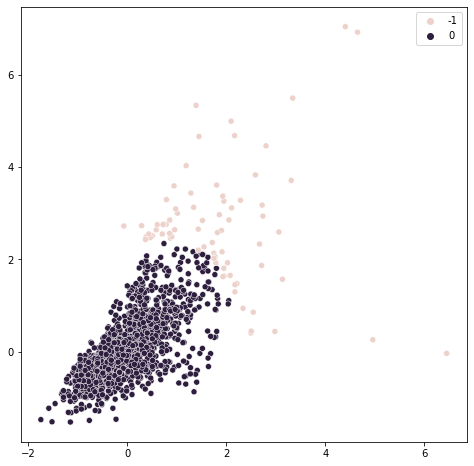

In [28]:
outlier_index = dbscan_outliers(df_houses,
                            "GrLivArea", "SalePrice",
                            dbscan_eps=.7,
                            dbscan_minsample=100,
                            get_cluster_num=-1)

print(f"Outliers identificados: {len(outlier_index)}")

# Isolation Forest

Finalmente vamos a ver la aplicaciónd e uno de los algoritmos más extendidos en la actualidad para la detección de outliers.

Esto es debido a su sencillez de implementar y a su eficacia,, como ya hemos visto durante la lección.

Para cambiar un poco vamos a realizar este ejercicio empleando la libreria H2O.

In [29]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgkmm95gz
  JVM stdout: /tmp/tmpgkmm95gz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgkmm95gz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_unknownUser_q6m1o3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


### Lectura de los datos

Vamos a leer los datos de los que dispone un departamenteo de Rrecursos humanos de sus trabjadores (ficticios) y vamos a emplear esta información para ver a que clase de trabajadores detecta como extraños nuestro isolation forest

In [30]:
employee_data = h2o.import_file('https://raw.githubusercontent.com/jguijarh/The_Valley_outliers_and_residuals/main/HR/HR_info_empleados.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Definimos el modelo con H2o

La forma de definir el modelo es muy similar a sklearn

Seleccionamos las features a utilizar para el entrenamiento del modelo

In [31]:
estimadores = ['Age', 'BusinessTravel', 
               'DistanceFromHome', 'Education', 
               'Gender', 'JobInvolvement', 'JobLevel', 
               'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 
               'OverTime', 'PercentSalaryHike',
               'PerformanceRating', 'TotalWorkingYears', 
               'TrainingTimesLastYear', 'YearsAtCompany', 
               'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

In [32]:
from h2o.estimators import H2OIsolationForestEstimator
isolation_model = H2OIsolationForestEstimator(model_id = "isolation_forest", 
                                              seed = 1993)
isolation_model.train(training_frame = employee_data, x = estimadores)

isolationforest Model Build progress: |███████████████████████████████████| 100%


Lo que nos predice el modelo de h2o es el mena_length, que viene a significar como de profunda es la rama en la que se ha quedado ese registro en función de sus variables para realizar su segregación.

Cuanto menor sea este valor, menos divisiones serán necesarias para dividir este registro y por lo tanto más propenso a ser elegido como outlier será.

Podemos ver como esto queda verificado con el histograma de este valor, al haber menos valores con un valor pequeño de mean_length

isolationforest prediction progress: |████████████████████████████████████| 100%


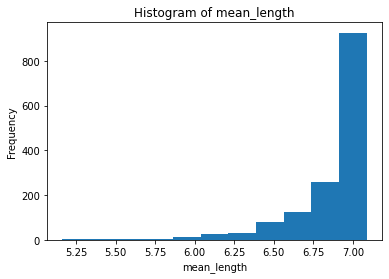

In [33]:
predicciones = isolation_model.predict(employee_data)
predicciones["mean_length"].hist()

A la vista de este histograma, podemos nostros mismos marcar un umbral en el cual identificar los outliers. Esto nos permite un poco más de versatilidad para parametrizar el modelo.

In [37]:
umbral_outlier = 5.8
anomalias = employee_data[predicciones["mean_length"] < umbral_outlier]
print("Numero de anomalias detectadas: " + str(anomalias.nrow))

Numero de anomalias detectadas: 24


Finalmente, calculamos añadimos este valor a nuestro dataframe de entrada al modelo.

In [38]:
data_con_outliers = employee_data[:, :]
data_con_outliers["anomalia"] = (predicciones["mean_length"] < umbral_outlier).ifelse("Si", "No")
data_con_outliers["anomalia"].table()

anomalia,Count
No,1446
Si,24


UIna vez fuiinalizada la detección podemos convertirlo en pandas dataframe y seguir trabajando een por ejemplo representaciones gráficas de los datos.

In [39]:
df_anomalias = h2o.as_list(data_con_outliers)

### Scatter plot de años que el empleado lleva en la empresa contra los años que lleva sin promocionar, coloreado por si el registro se considera outlier o no 

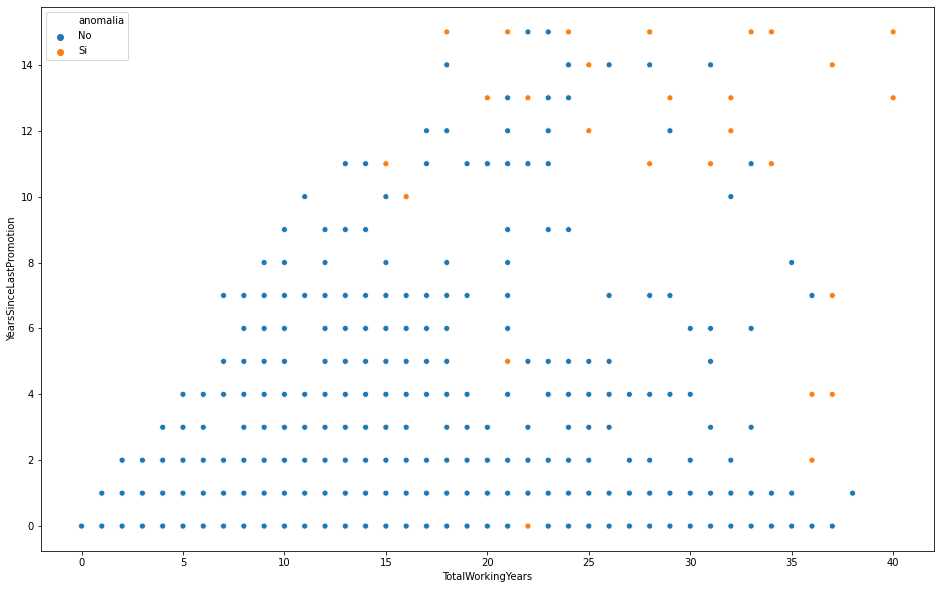

In [ ]:
plt.figure(figsize=(16, 10))
sns.scatterplot(x="TotalWorkingYears", y="YearsSinceLastPromotion", hue= 'anomalia',
            data=df_anomalias);

### Futuros pasos o lineas a investigar

1. Para el caso del isolation forest, construid un arbol, que tenga como variable target la anomalia y estudiad los cortes que hace el árbol para ver porque discrimina ciertas regiones de los datos.
2. Probar el algoritmo Isolation forest pero con sklearn y usad un volumen de datos más grande. Comparad tiempos.